In [ ]:
# libraries

import os
import re
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pickle import dump, load

from pathlib import Path
from PIL import Image

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3,preprocess_input

In [ ]:
# download glove vectores

!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

--2023-01-14 16:48:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-14 16:48:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-14 16:48:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


# Download Dataset

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

# Let's see what is the different between token and lemma token file in the text file

In [ ]:
texts_file = open('/content/all_captions/Flickr8k.token.txt', 'r')
texts_file = texts_file.read()
texts_file = texts_file.split('\n')
texts_file = texts_file[:-1]
texts_file[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [ ]:
lem_file = open('/content/all_captions/Flickr8k.lemma.token.txt', 'r')
lem_file = lem_file.read()
lem_file = [sen for sen in lem_file.split('\n') if sen.startswith(texts_file[1][:20])]
lem_file

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress be climb up a set of stair in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl go into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climb into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climb the stair to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress go into a wooden cabin .']

***I prefer to work with the token file, not the lemma, because I want generate some meaningful sentences for images***

In [ ]:
texts_dict = {}

for des in texts_file:
  if des.split('\t')[0][:-2] not in texts_dict:
    texts_dict[des.split('\t')[0][:-2]] = [des.split('\t')[1]]
  else:
    texts_dict[des.split('\t')[0][:-2]].append(des.split('\t')[1])

texts_df = pd.DataFrame({'ImageName':list(texts_dict.keys()),
                         'ImageDescription':list(texts_dict.values())})

In [ ]:
image_dir = Path('/content/all_images/Flicker8k_Dataset')
image_paths = list(image_dir.glob(r'**/*.jpg'))
image_str_paths = pd.Series(image_paths, name='ImagePath').astype(str)
image_names = pd.Series([i.split("/")[-1] for i in image_str_paths], name='ImageName')
df = pd.concat([image_str_paths,image_names], axis=1)
df = df.merge(texts_df, on='ImageName')
df.head(5)

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/37448321...,3744832122_2f4febdff6.jpg,"[A boy pitches in a baseball game ., A boy win..."
1,/content/all_images/Flicker8k_Dataset/37900664...,379006645_b9a2886b51.jpg,[A black and brown dog is running between two ...
2,/content/all_images/Flicker8k_Dataset/22233822...,2223382277_9efa58ec45.jpg,[A boy in a red uniform plays hockey outside ....
3,/content/all_images/Flicker8k_Dataset/10568733...,1056873310_49c665eb22.jpg,[A brown dog is running after a black dog on a...
4,/content/all_images/Flicker8k_Dataset/36074054...,3607405494_0df89110a6.jpg,[Three black dogs wearing muzzles race through...


# Now let's look at Images

In [ ]:
def show_image(df):
  plt.figure(figsize=(20,10), dpi=100)
  for i in range(3):
    image_name = df['ImagePath'][i]
    captions = df.loc[df['ImagePath']==image_name, 'ImageDescription']

    ax = plt.subplot(1, 3, i+1)
    img = Image.open(image_name)
    plt.imshow(img.resize((229,229)))
    ax.set_title([cap[0] for cap in captions][0])

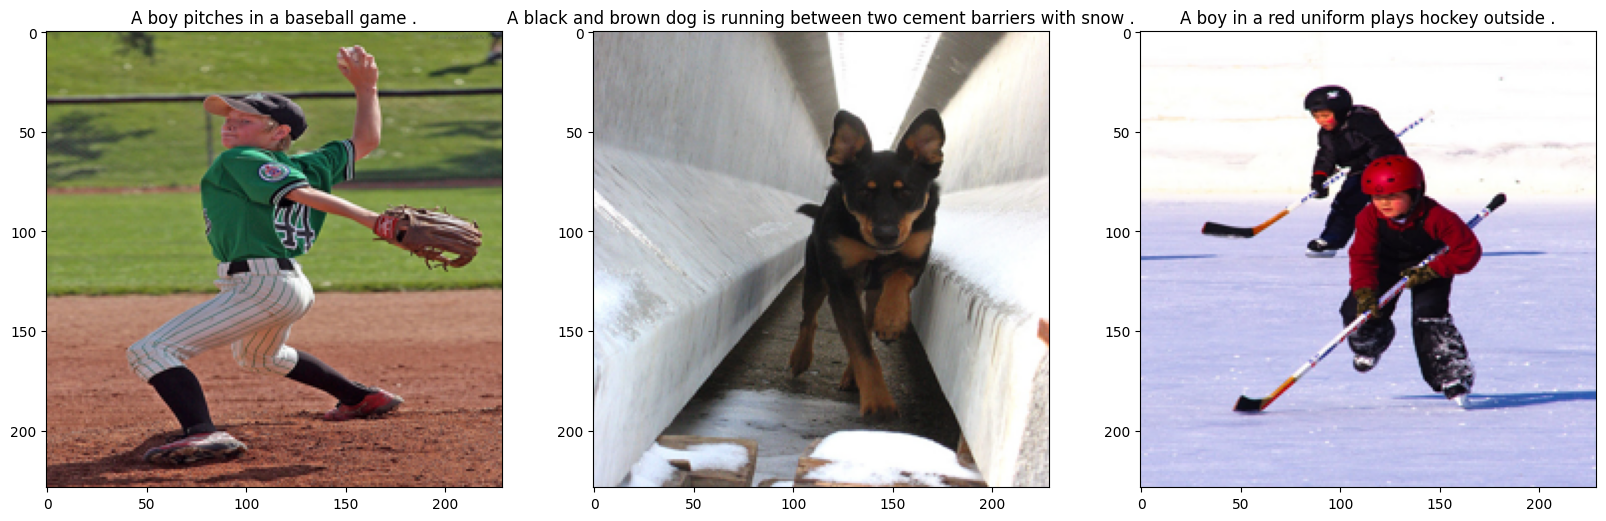

In [ ]:
show_image(df)

# Text processing

In [ ]:
df.head()

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/37448321...,3744832122_2f4febdff6.jpg,"[A boy pitches in a baseball game ., A boy win..."
1,/content/all_images/Flicker8k_Dataset/37900664...,379006645_b9a2886b51.jpg,[A black and brown dog is running between two ...
2,/content/all_images/Flicker8k_Dataset/22233822...,2223382277_9efa58ec45.jpg,[A boy in a red uniform plays hockey outside ....
3,/content/all_images/Flicker8k_Dataset/10568733...,1056873310_49c665eb22.jpg,[A brown dog is running after a black dog on a...
4,/content/all_images/Flicker8k_Dataset/36074054...,3607405494_0df89110a6.jpg,[Three black dogs wearing muzzles race through...


In [ ]:
def clean_text(descriptions):
  for i in range(len(descriptions)):
    sentence = descriptions[i]
    sentence = re.sub('[^a-z A-Z]', '', sentence)
    sentence = str(sentence).lower()
    sentence = sentence.split()
    sentence = [token for token in sentence if len(token)>1]
    descriptions[i] = '<start> ' + " ".join(sentence) + ' <end>'
  return descriptions

In [ ]:
df['ImageDescription'] = df['ImageDescription'].apply(clean_text)

In [ ]:
vocab = set()
for i in range(len(df)):
  [vocab.update(d.split()) for d in df['ImageDescription'][i]]
initial_vocab_size = len(vocab)
initial_vocab_size

8767

In [ ]:
def dict_to_list(descriptions):
  all_desc = []
  for i in range(len(df)):
      [all_desc.append(d) for d in descriptions[i]]
  return all_desc

In [ ]:
text_lst = dict_to_list(df['ImageDescription'])
max_len = max(len(sen.split()) for sen in text_lst)
max_len

34

In [ ]:
df.head(2)

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/37448321...,3744832122_2f4febdff6.jpg,"[<start> boy pitches in baseball game <end>, <..."
1,/content/all_images/Flicker8k_Dataset/37900664...,379006645_b9a2886b51.jpg,[<start> black and brown dog is running betwee...


##Making weight matrix for Word Embedding with Word2vec and Glove

Word2Vec

In [ ]:
def word2vec_embed():
  # convert all the descriptions in the descriptions lists to a list of lists contains all the words in the descriptions --> what Word2Vec wants
  text = [i.split() for i in text_lst]
  embedding_model = Word2Vec(sentences=text,
                            size=100,
                            min_count=1,
                            window=5,
                            workers=4)

  # create embadding matrix based on wor2vec
  word2vec_embedding_matrix = embedding_model.wv.vectors
  vocab_size = word2vec_embedding_matrix.shape[0]
  tokenizer = Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(text_lst)
  return tokenizer, vocab_size, word2vec_embedding_matrix

Glove

In [ ]:
def glove_embed():
  # create glove dict
  embeddings_dict = {}
  with open('/tmp/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype="float32")
        embeddings_dict[word] = vec

  # in glove, we need define the shape of the embedding matrix ourself, then we need to fit tokenizer on our curpes first and then continue
  tokenizer = Tokenizer(num_words=initial_vocab_size)
  tokenizer.fit_on_texts(text_lst)
  word2idx = tokenizer.word_index

  # create embadding matrix based on glove
  glove_embedding_matrix = np.zeros((len(word2idx) + 1, 100))
  for word, i in word2idx.items():
    if i < initial_vocab_size:
      embedding_vector = embeddings_dict.get(word)
      if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

  vocab_size = glove_embedding_matrix.shape[0]
  return tokenizer, vocab_size, glove_embedding_matrix

# Image Proccessing

In [ ]:
features = []
feature_extractor = Xception(include_top=False, pooling='avg')
for image in tqdm(df['ImagePath']):
  img = Image.open(image)
  img = img.resize((229,229))
  img = np.expand_dims(img, axis=0)
  img = img/127.5
  img-=1

  img_feature = feature_extractor.predict(img, verbose=0)
  features.append(img_feature)

83683744/83683744 [==============================] - 4s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
df['ImageFeature'] = features
dump(features, open("features.p", "wb"))

In [ ]:
# features = load(open("features.p", "rb"))
# df['ImageFeature'] = features

## Generate proper DataSet for Image Captioning

In [ ]:
def data_generator(df, max_len, embedding, num_photos_per_batch):
  tokenizer = embedding[0]
  vocab_size = embedding[1]
  X1, X2, y = list(), list(), list()
  n=0
  while 1:
      for i in range(len(df)):
          n+=1
          features = df['ImageFeature'][i][0]
          descriptions = df['ImageDescription'][i]

          for desc in descriptions:
              seq = tokenizer.texts_to_sequences([desc])
              seq = seq[0]
              for i in range(1,len(seq)):
                  in_seq , op_seq = seq[:i],seq[i]
                  in_seq = pad_sequences([in_seq], maxlen=max_len, padding="post")[0]
                  op_seq = to_categorical([op_seq],num_classes=vocab_size)[0]
                  X1.append(features)
                  X2.append(in_seq)
                  y.append(op_seq)
          if n==num_photos_per_batch:
              yield [[np.array(X1), np.array(X2)], np.array(y)]
              X1, X2, y = list(), list(), list()
              n=0

## Build the Model

In [ ]:
def define_model(embedding, max_len):

    inputs1 = tf.keras.layers.Input(shape=(2048,))
    fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
    fe2 = tf.keras.layers.Dense(300, activation='relu')(fe1)

    embedding_matrix = embedding[2]
    vocab_size = embedding[1]

    inputs2 = tf.keras.layers.Input(shape=(max_len,))
    se1 = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                    output_dim=embedding_matrix.shape[1],
                                    mask_zero=True,
                                    weights=[embedding_matrix],
                                    trainable=False)(inputs2)
    se2 = tf.keras.layers.Dropout(0.5)(se1)
    se3 = tf.keras.layers.LSTM(300)(se2)

    decoder1 = tf.keras.layers.Add()([fe2, se3])
    decoder2 = tf.keras.layers.Dense(300, activation='relu')(decoder1)
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)

    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    return model

## Prediction Phase

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

def generate_desc(model, tokenizer, features, max_len):
  in_text = 'start'
  for i in range(max_len):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_len)
    pred = model.predict([features,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        break
  return in_text

def test_features_extraction(test_img):
  test_features = []
  img = Image.open(test_img)
  img = img.resize((229,229))
  img = np.expand_dims(img, axis=0)
  img = img/127.5
  img-=1
  img_feature = feature_extractor.predict(img, verbose=0)
  test_features.append(img_feature)
  return test_features

In [ ]:
test_image1 = '/content/GettyImages-470691529-5949be9d5f9b58d58a0354c9.jpg'
test_features1 = test_features_extraction(test_image1)

test_image2 = '/content/senior-dog-cat-cuddling-web.jpg'
test_features2 = test_features_extraction(test_image2)

In [ ]:
batch_size = number_pics_per_bath = 10
steps = len(df)//number_pics_per_bath

## Word2Vec Performance

In [ ]:
# Data Generating
word2vec_embedding = word2vec_embed()
word2vec_generator = data_generator(df, max_len, word2vec_embedding, number_pics_per_bath)
word2vec_model = define_model(word2vec_embedding, max_len)

# Training Phase
word2vec_model.fit_generator(word2vec_generator, epochs=20, steps_per_epoch=steps, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 100)      876700      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

<ipython-input-28-e1de30119099>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  word2vec_model.fit_generator(word2vec_generator, epochs=20, steps_per_epoch=steps, verbose=1)


809/809 [==============================] - 43s 48ms/step - loss: 4.7803
Epoch 2/20
809/809 [==============================] - 38s 48ms/step - loss: 3.9073
Epoch 3/20
809/809 [==============================] - 38s 48ms/step - loss: 3.6006
Epoch 4/20
809/809 [==============================] - 39s 48ms/step - loss: 3.3909
Epoch 5/20
809/809 [==============================] - 39s 48ms/step - loss: 3.2251
Epoch 6/20
809/809 [==============================] - 39s 48ms/step - loss: 3.0898
Epoch 7/20
809/809 [==============================] - 38s 47ms/step - loss: 2.9819
Epoch 8/20
809/809 [==============================] - 38s 47ms/step - loss: 2.8959
Epoch 9/20
809/809 [==============================] - 38s 47ms/step - loss: 2.8269
Epoch 10/20
809/809 [==============================] - 38s 47ms/step - loss: 2.7695
Epoch 11/20
809/809 [==============================] - 38s 47ms/step - loss: 2.7200
Epoch 12/20
809/809 [==============================] - 38s 47ms/step - loss: 2.6780
Epoch 13/20


start man in black and white shirt is climbing up rock wall end


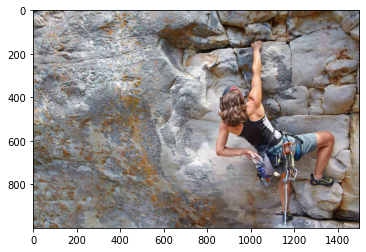

In [ ]:
# Prediction Phase
word2vec_description1 = generate_desc(word2vec_model, word2vec_embedding[0], test_features1, max_len)
plt.imshow(Image.open(test_image1))
print(word2vec_description1)

start dog breastfeeding at the camera end


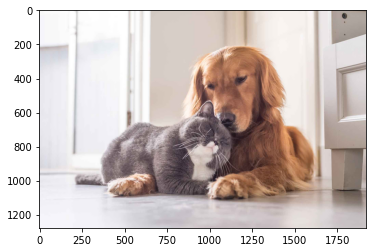

In [ ]:
word2vec_description2 = generate_desc(word2vec_model, word2vec_embedding[0], test_features2, max_len)
plt.imshow(Image.open(test_image2))
print(word2vec_description2)

## Glove Performance

In [ ]:
# Data Generating
glove_embedding = glove_embed()
glove_generator = data_generator(df, max_len, glove_embedding, number_pics_per_bath)
glove_model = define_model(glove_embedding, max_len)

# Training Phase
glove_model.fit_generator(glove_generator, epochs=20, steps_per_epoch=steps, verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 100)      876600      ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

<ipython-input-38-bfd69202475f>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  glove_model.fit_generator(glove_generator, epochs=20, steps_per_epoch=steps, verbose=1)


809/809 [==============================] - 43s 48ms/step - loss: 4.6845
Epoch 2/20
809/809 [==============================] - 38s 48ms/step - loss: 3.8162
Epoch 3/20
809/809 [==============================] - 39s 48ms/step - loss: 3.5079
Epoch 4/20
809/809 [==============================] - 38s 47ms/step - loss: 3.3022
Epoch 5/20
809/809 [==============================] - 38s 47ms/step - loss: 3.1426
Epoch 6/20
809/809 [==============================] - 37s 46ms/step - loss: 3.0118
Epoch 7/20
809/809 [==============================] - 37s 46ms/step - loss: 2.9065
Epoch 8/20
809/809 [==============================] - 37s 46ms/step - loss: 2.8202
Epoch 9/20
809/809 [==============================] - 38s 47ms/step - loss: 2.7558
Epoch 10/20
809/809 [==============================] - 38s 47ms/step - loss: 2.6957
Epoch 11/20
809/809 [==============================] - 38s 47ms/step - loss: 2.6501
Epoch 12/20
809/809 [==============================] - 38s 47ms/step - loss: 2.6123
Epoch 13/20


start man is abseiling on rock face end


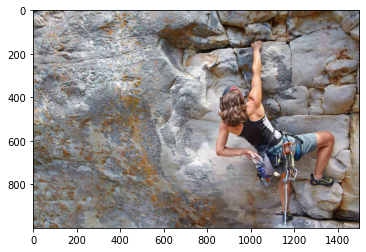

In [ ]:
# Prediction Phase
glove_description1 = generate_desc(glove_model, glove_embedding[0], test_features1, max_len)
plt.imshow(Image.open(test_image1))
print(glove_description1)

start brown dog nursing on the grass end


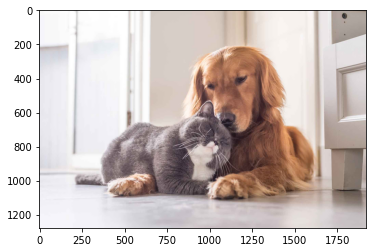

In [ ]:
glove_description2 = generate_desc(glove_model, glove_embedding[0], test_features2, max_len)
plt.imshow(Image.open(test_image2))
print(glove_description2)